# Dense Neural Network Model

#### 1. Import the necessary libraries

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from keras import Sequential
import keras_tuner as kt
from keras.layers  import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from utils import split_train_validate_test, DataPreprocessor
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

### 2. Import Dataset

In [2]:
dataset = pd.read_csv('./training_data/GBPUSD_open_5year.csv')

### 3. Plot the training data into graph

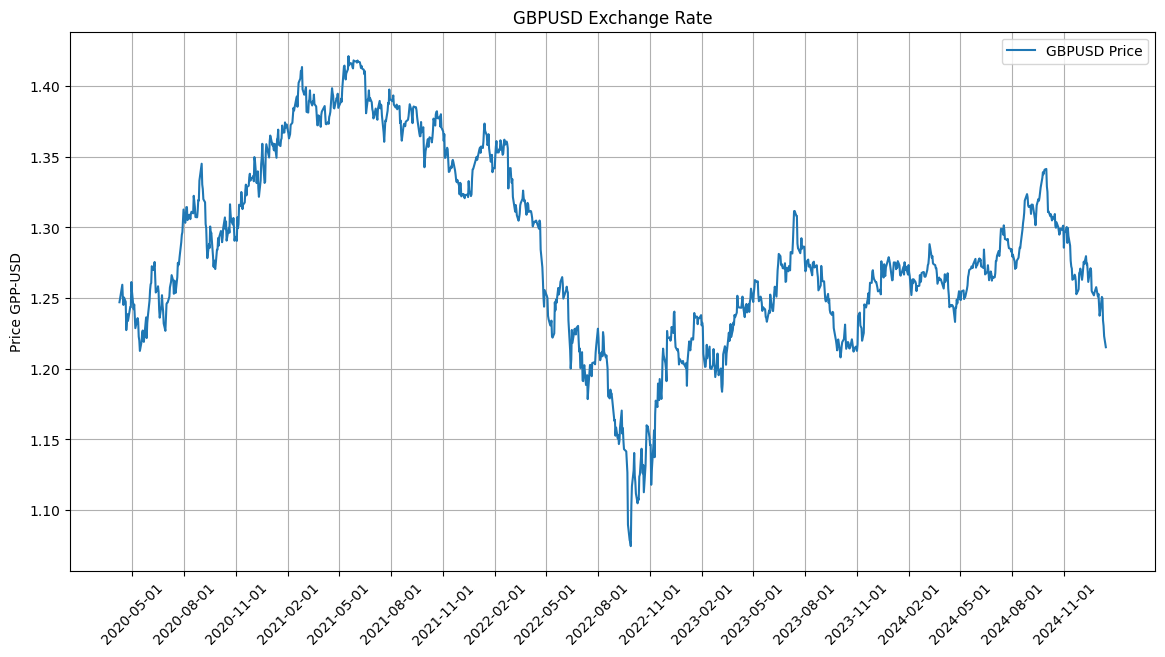

In [20]:
df = dataset

## Convert unix time to date
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.sort_values(by="Date", inplace=True)


## Plot the training data into graph
plt.figure(figsize=(14,7))
plt.title('GBPUSD Exchange Rate')
plt.ylabel('Price GPP-USD')


## Plot the data
plt.plot(df['Date'], df['Open'], label='GBPUSD Price')
plt.xticks(pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='3MS'))


## Format the data 
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


### Split the dataset into Training, Validation and Test data

In [22]:
from utils import split_train_validate_test


train_data, val_data, test_data = split_train_validate_test(df, 0.7, 0.15, 0.15)

print("Training Data Information:")
print("--------------------------")
print(f"Training Data: {train_data}")
print(f"Validation Data: {val_data.shape}")
print(f"Test Data: {test_data.shape}")


Training Data Information:
--------------------------
Training Data:      Index       Date    Open        Time
0        0 2020-04-09  1.2470  1586390400
1        1 2020-04-14  1.2594  1586822400
2        2 2020-04-15  1.2498  1586908800
3        3 2020-04-16  1.2451  1586995200
4        4 2020-04-17  1.2504  1587081600
..     ...        ...     ...         ...
835    835 2023-08-04  1.2757  1691107200
836    836 2023-08-07  1.2772  1691366400
837    837 2023-08-08  1.2722  1691452800
838    838 2023-08-09  1.2732  1691539200
839    839 2023-08-10  1.2735  1691625600

[840 rows x 4 columns]
Validation Data: (180, 4)
Test Data: (180, 4)


### Preprocess the data with MinMax Scaler

In [48]:
pre_processor = DataPreprocessor()

pre_processor.fit(train_data)
X_train, y_train = pre_processor.transform(train_data)
X_train = X_train[:,0].reshape(-1, 1)

pre_processor.fit(val_data)
X_val, y_val = pre_processor.transform(val_data)
print(X_val)
X_val = X_val[:,0].reshape(-1, 1)

pre_processor.fit(test_data)
X_test, y_test = pre_processor.transform(test_data)
X_test = X_test[:,0].reshape(-1, 1)

scaler = MinMaxScaler()
train_date_scaled = scaler.fit_transform(np.array(train_data['Index']).reshape(-1, 1))
val_date_scaled = scaler.fit_transform(np.array(val_data['Index']).reshape(-1, 1))
test_date_scaled = scaler.fit_transform(np.array(test_data['Index']).reshape(-1, 1))

print(X_test, X_val, X_test)


[[0.79026217 0.        ]
 [0.72534332 0.01158301]
 [0.83021223 0.01544402]
 [0.84019975 0.01930502]
 [0.84519351 0.02316602]
 [0.79400749 0.02702703]
 [0.80774032 0.03861004]
 [0.81398252 0.04247104]
 [0.75280899 0.04633205]
 [0.70911361 0.05019305]
 [0.5917603  0.05405405]
 [0.63545568 0.06949807]
 [0.80774032 0.07335907]
 [0.74032459 0.07722008]
 [0.67290886 0.08108108]
 [0.67166042 0.09266409]
 [0.5917603  0.0965251 ]
 [0.51310861 0.1003861 ]
 [0.49438202 0.1042471 ]
 [0.50561798 0.10810811]
 [0.56054931 0.11969112]
 [0.48189763 0.12355212]
 [0.51186017 0.12741313]
 [0.41822722 0.13127413]
 [0.39325843 0.13513514]
 [0.37453184 0.14671815]
 [0.4019975  0.15057915]
 [0.39700375 0.15444015]
 [0.25967541 0.15830116]
 [0.2309613  0.16216216]
 [0.14731586 0.17374517]
 [0.10986267 0.17760618]
 [0.06242197 0.18146718]
 [0.14731586 0.18532819]
 [0.15855181 0.18918919]
 [0.05243446 0.2007722 ]
 [0.         0.2046332 ]
 [0.04369538 0.20849421]
 [0.09987516 0.21235521]
 [0.13483146 0.21621622]


### Hyper-tune the Dense Neural Network using Hyperband method

In [33]:
#build model
def build_model(hp):
    model = Sequential()
    
    num_layers_params = hp.Int('num_layers', 5, 6, step=1)

    # Tune number of units for the first layer
    # first_units_params= hp.Int('units_0', min_value=4, max_value=40, step=4)
    print(X_train.shape)
    model.add(Dense(units=20, activation="relu", input_dim=1))

    # Tune hidden layers
    for i in range(1, num_layers_params):  
        model.add(Dense(units=hp.Int(f'{i}_unit_param', min_value=20, max_value=20, step=1), activation='relu'))

    # Output layer (no activation for regression)
    model.add(Dense(units=1))

    # Tune optimizer choice
    optimizer_choice = hp.Choice('optimizer', ['adam'])
    # learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')

    if optimizer_choice == 'adam':
        optimizer = Adam()
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop()
    else:
        optimizer = SGD()

    # Compile the model with tunable optimizer
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

    return model
tuner = kt.Hyperband(build_model, objective='val_mse', factor=3, directory='dnn_cache', project_name='gbpusd conversion')
tuner.search(train_date_scaled, X_train, epochs=50, validation_data=(val_date_scaled, X_val), verbose=1)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Hyperparameters: {best_hps.values}")


Trial 246 Complete [00h 00m 06s]
val_mse: 0.05058304965496063

Best val_mse So Far: 0.03903137519955635
Total elapsed time: 02h 10m 02s
Best Hyperparameters: {'num_layers': 5, 'units_0': 32, '1_unit_param': 24, '2_unit_param': 28, '3_unit_param': 8, '4_unit_param': 4, 'optimizer': 'adam', 'learning_rate': 0.009198592029038246, '5_unit_param': 16, '6_unit_param': 4, '7_unit_param': 4, '8_unit_param': 12, '9_unit_param': 20, '10_unit_param': 20, 'tuner/epochs': 100, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


### Get the best model from the hyperparameters

In [36]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters and Metrics:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

# Build and train the best model
best_model = tuner.hypermodel.build(best_hps)  # Ensure `build` only gets `best_hps`

best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])

best_history = best_model.fit(train_date_scaled, X_train, epochs=100, batch_size=32, validation_data=(val_date_scaled, X_val))

Best Hyperparameters and Metrics:
num_layers: 5
units_0: 32
1_unit_param: 24
2_unit_param: 28
3_unit_param: 8
4_unit_param: 4
optimizer: adam
learning_rate: 0.009198592029038246
5_unit_param: 16
6_unit_param: 4
7_unit_param: 4
8_unit_param: 12
9_unit_param: 20
10_unit_param: 20
tuner/epochs: 100
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
(840, 2)
Epoch 1/100


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3971 - mae: 0.5686 - mse: 0.3971 - val_loss: 0.3309 - val_mae: 0.5066 - val_mse: 0.3309
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3502 - mae: 0.5296 - mse: 0.3502 - val_loss: 0.3051 - val_mae: 0.4817 - val_mse: 0.3051
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3245 - mae: 0.5069 - mse: 0.3245 - val_loss: 0.2811 - val_mae: 0.4585 - val_mse: 0.2811
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2937 - mae: 0.4771 - mse: 0.2937 - val_loss: 0.2591 - val_mae: 0.4376 - val_mse: 0.2591
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2692 - mae: 0.4541 - mse: 0.2692 - val_loss: 0.2388 - val_mae: 0.4182 - val_mse: 0.2388
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2508 - mae: 0.4357 - mse: 0.2508 - val_loss: 0.2203 - val_mae: 0.4007 - val_mse: 0.2203
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2374 - mae: 0.4217 - mse: 0.2374 - val_loss: 0.2033 - val

### Evaluation on Test & Validation data  

In [ ]:
# Evaluate the model on the test data
test_loss, test_mae, test_mse = best_model.evaluate(val_date_scaled, X_val, verbose=1)

# Print the evaluation metrics
print("Evaluation Metrics on Validation Data:")
print(f"Mean Absolute Error (MAE): {test_mae}")
print(f"Mean Squared Error (MSE): {test_mse}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0737 - mae: 0.2288 - mse: 0.0737
Evaluation Metrics on Validation Data:
Mean Absolute Error (MAE): 0.21128103137016296
Mean Squared Error (MSE): 0.06321603804826736
Mean Absolute Percentage Error (MAPE): nan%


/var/folders/xz/1gn0m18n5k1bjmbt205k50cm0000gn/T/ipykernel_74960/1992514614.py:10: RuntimeWarning: invalid value encountered in divide
  mape = np.mean(np.abs((X_val.flatten() - y_val_actual.flatten()) / y_val_actual.flatten())) * 100


### Test set & Validation set plot

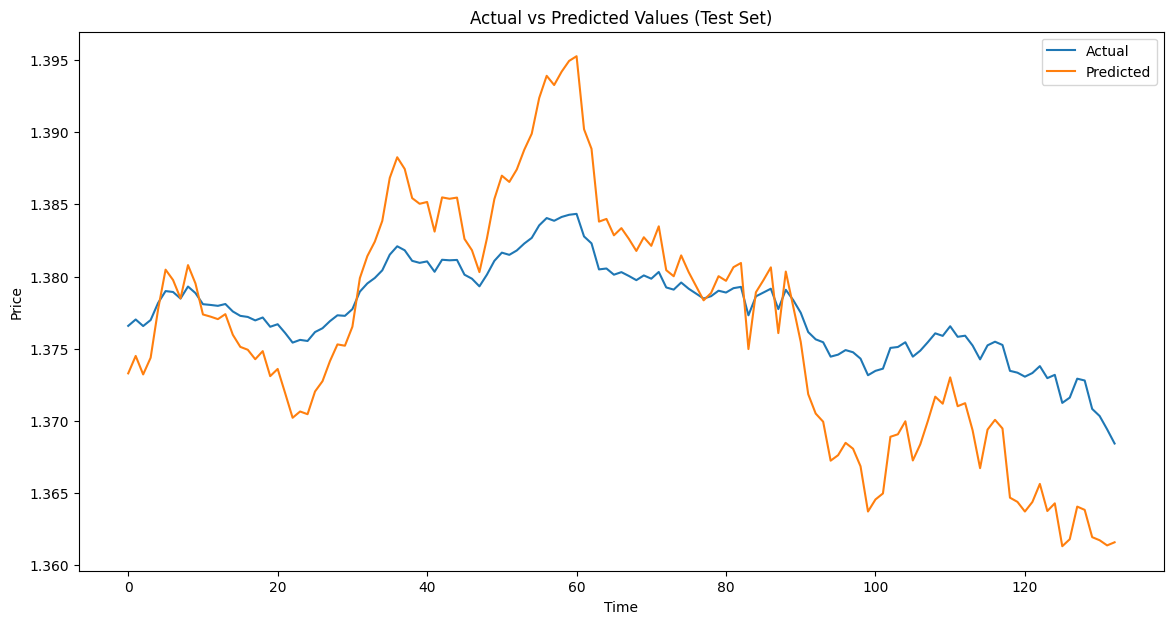

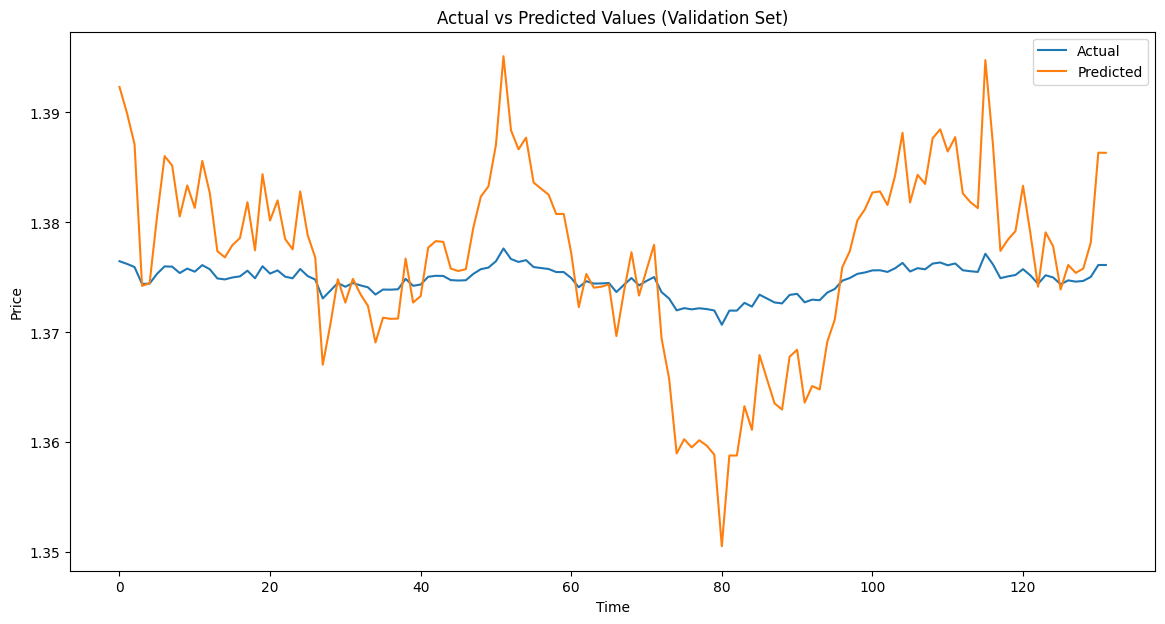

In [16]:
# Plot actual vs. predicted values for the test set
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Values (Test Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot actual vs. predicted values for the validation set
plt.figure(figsize=(14, 7))
plt.plot(y_val_actual, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.title('Actual vs Predicted Values (Validation Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

### Print the data range on whole data

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step
Best Model evaluation on whole data set Performance on Test Data:
Mean Absolute Error (MAE): 0.0003
Mean Squared Error (MSE): 0.0000
Mean Absolute Percentage Error (MAPE): 0.02%
[1.5067102  1.51100804 1.50768068 ... 1.50092198 1.4983918  1.49568832] [1.50724823 1.51161686 1.50821987 ... 1.50096989 1.498583   1.49634542]


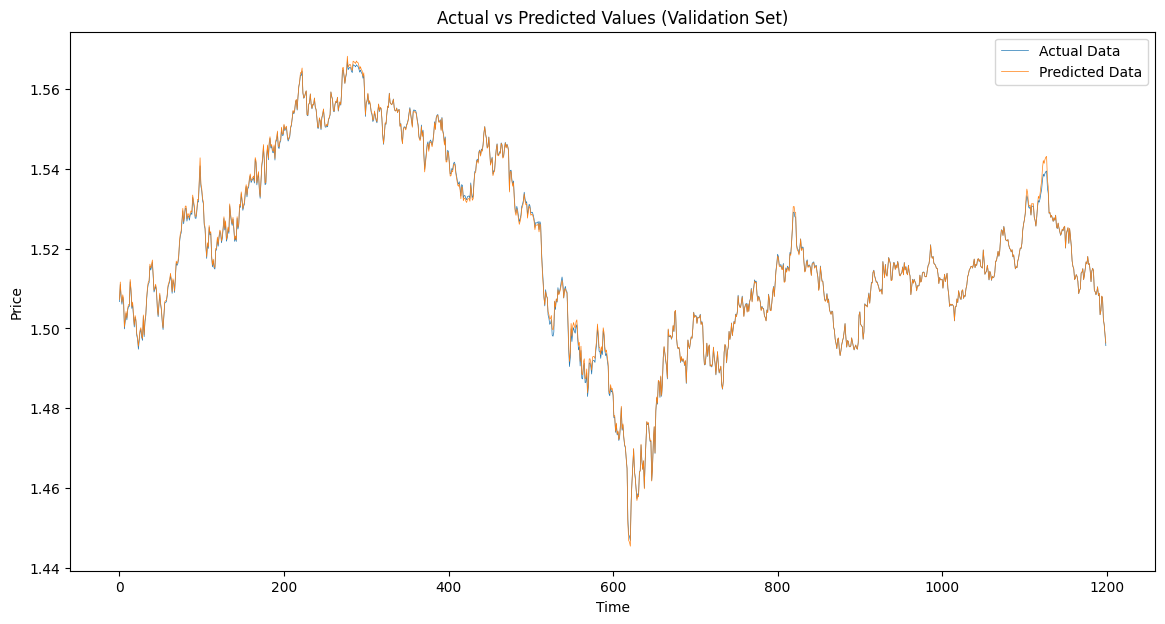

In [17]:
pre_processor.fit(dataset)
x_full, y_full = pre_processor.transform(dataset)

y_full_actual, y_full_pred =  evaluate_model(best_model, x_full, y_full, "Best Model evaluation on whole data set", scaler=pre_processor.scaler)
print(y_full_actual, y_full_pred)

# Plot actual vs. predicted values for the validation set
plt.figure(figsize=(14, 7))
plt.plot(y_full_actual,  alpha=1, linewidth=0.5, label="Actual Data")
plt.plot( y_full_pred,  linewidth=0.5, label="Predicted Data")
plt.title('Actual vs Predicted Values (Validation Set)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


### MSE and MAE plot

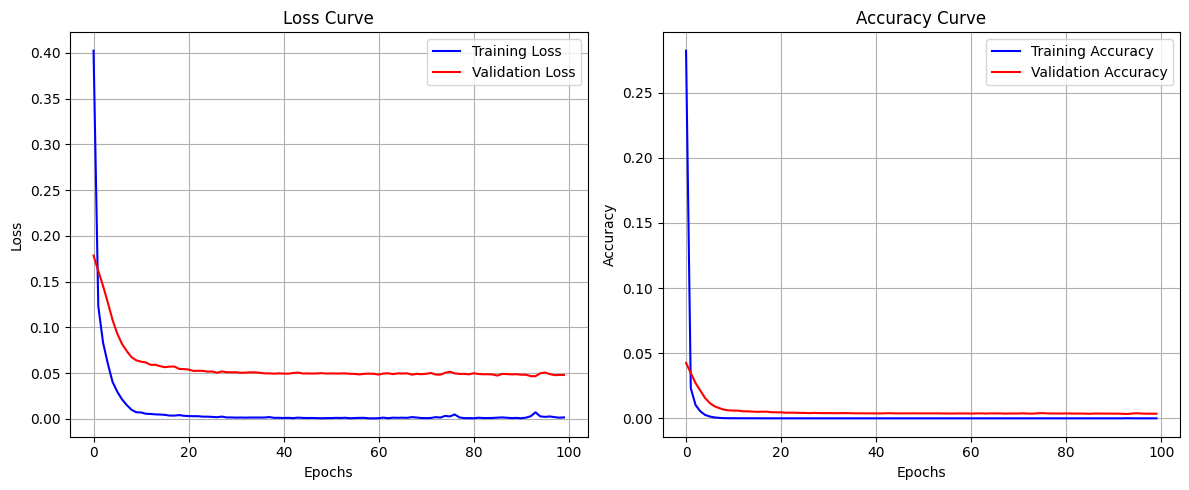

In [28]:
# Plotting the learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Training Loss', color='blue')
    plt.plot(history.history['val_mae'], label='Validation Loss', color='red')
    plt.title('Loss Curve')
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mse'], label='Training Accuracy', color='blue')
    plt.plot(history.history['val_mse'], label='Validation Accuracy', color='red')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_learning_curves(best_history)


### Save the output

In [29]:
best_model.save('./output/DNN.h5')